In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model, neighbors, ensemble, naive_bayes, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE, SMOTENC

import plotly
plotly.tools.set_credentials_file(username='extralime', api_key='q3tUGZrv40fkKyR4uPuL')
import plotly.plotly as py
import plotly.graph_objs as go
import colorlover as cl

from IPython.display import Image
from IPython.display import HTML

import warnings

warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')

def model_me(X_train,X_test, y_train, y_test):
    knn = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    print('Results of KNN:\n')
    print('\nClassification Report:KNN\n')
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cbar=False)
    plt.show()
    print('ROC_AUC _SCORE:')
    print(roc_auc_score(y_test,y_pred))
    rfc = ensemble.RandomForestClassifier(n_estimators=250, class_weight='balanced',criterion='entropy')
    rfc.fit(X_train,y_train)
    y_pred = rfc.predict(X_test)
    print('\n\nResults of Random Forest:\n')
    print('\nClassification Report:RFC\n')
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cbar=False)
    plt.show()
    print('ROC_AUC _SCORE:')
    print(roc_auc_score(y_test,y_pred))
    
    lrc = linear_model.LogisticRegression(C=10, penalty='l1')
    lrc.fit(X_train,y_train)
    y_pred = lrc.predict(X_test)
    print('\n\nResults of Logistic Regression (lasso):\n')
    print('\nClassification Report:LR1\n')
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cbar=False)
    plt.show()
    print('ROC_AUC _SCORE:')
    print(roc_auc_score(y_test,y_pred))
    lrc = linear_model.LogisticRegression(C=10, penalty='l2')
    lrc.fit(X_train,y_train)
    y_pred = lrc.predict(X_test)
    print('\n\nResults of Logistic Regression (Ridge):\n')
    print('\nClassification Report:LR2\n')
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cbar=False)
    plt.show()
    print('ROC_AUC _SCORE:')
    print(roc_auc_score(y_test,y_pred))
    gbc = ensemble.GradientBoostingClassifier(n_estimators=500,max_depth=4,loss='exponential')
    gbc.fit(X_train,y_train)
    y_pred = gbc.predict(X_test)
    print('\n\nResults of Gradient Boosting:\n')
    print('\nClassification Report:GBC\n')
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cbar=False)
    plt.show()
    print('ROC_AUC _SCORE:')
    print(roc_auc_score(y_test,y_pred))


colors = cl.to_rgb(cl.scales['10']['div']['BrBG'])
HTML(cl.to_html( cl.scales['10']['div']['BrBG'] ))

/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#import the data, manage nulls and date field
df = pd.read_csv('lemon_train.csv')

df.PurchDate = pd.to_datetime(df.PurchDate)
df['pyear'] = df['PurchDate'].dt.year.astype(int)
df['pmonth'] = df['PurchDate'].dt.month.astype(int)
df['pday'] = df['PurchDate'].dt.day.astype(int)
#Drop the date and other columns
df.drop(['RefId', 'BYRNO', 'AUCGUART', 'PRIMEUNIT',
         'VNZIP1','WheelType', 'VehYear','PurchDate'],1,inplace=True)
df.dropna(inplace=True)
#add 1 to vehicle age (for math)
df.VehicleAge = [x+1 for x in df.VehicleAge]
df.shape


(67275, 29)

### Create dummy variables for extracted keyword from problematic categorical variables

In [3]:
#Separate and combine columns of interest
models = df.Model
submods = df.SubModel
trims = df.Trim
chars = df[['Model','SubModel','Trim']] 

#keyword list for model characteristics
mod_chars = ['2WD','V6','4C','PICKUP','6C','FWD',
             '4WD','AWD','SFI','EFI','DOHC','I4','MPI']

#keyowrd list for submodel characteristics
submod_chars = ['SEDAN','4D','EXT','CAB','2D','CAB','WAGON',
                'REG','FFV','PASSENGER','SUV','SPORT',
                'UTILITY','QUAD','COUPE','MINIVAN','CUV']

#Create a dataframe and extract keywords from model and submodel.
sub_val_sets, mod_val_sets = pd.DataFrame(),pd.DataFrame()

for key in submod_chars:
    subs = np.where(submods.str.contains(key),1,0) #create array for dummied char prescence    
    sub_val_sets[key] = subs #insert to dataframe
for key in mod_chars:
    mods = np.where(models.str.contains(key),1,0)
    mod_val_sets[key] = mods


In [4]:
#combine the two characteristic sets
char_dummies = pd.concat([mod_val_sets,sub_val_sets],axis=1)  

# Extract engine displacement sizes

In [5]:
displacement = chars.SubModel.str.split('.').reset_index()
disp_ok = []
#Only keep entries with engine size len(Submodel) == 2
for model in displacement.SubModel:
    if len(model) == 2:
        disp_ok.append(model)
        
#Finally take the last element from 1st list, insert '.' add lasr element of 2nd list
displacements = []
for i in range(len(disp_ok)):
    beg = disp_ok[i][0][-1]
    end = disp_ok[i][1][0]
    whole = beg+'.'+end
    displacements.append(whole)
displacements = pd.Series(displacements)
ds_val_cnts = displacements.value_counts().reset_index()

In [6]:
#create dummie matrix for engine displacements
disp_keys = pd.DataFrame()
for key in ds_val_cnts['index']:
    dsps = np.where(df.SubModel.str.contains(key),1,0) #create array for dummied char prescence    
    disp_keys[key] = dsps #insert to dataframe

# examining our features

## Expirementing with the continuous data


In [7]:
#combine the three new dataframes
mod_val_sets.reset_index(drop=True,inplace=True)
sub_val_sets.reset_index(drop=True,inplace=True)
disp_keys.reset_index(drop=True,inplace=True)

dummy_feats = pd.concat([mod_val_sets,sub_val_sets,disp_keys],axis=1)

In [8]:
dummy_feats['IsBadBuy'] = df.IsBadBuy
dummy_feats.columns

Index(['2WD', 'V6', '4C', 'PICKUP', '6C', 'FWD', '4WD', 'AWD', 'SFI', 'EFI',
       'DOHC', 'I4', 'MPI', 'SEDAN', '4D', 'EXT', 'CAB', '2D', 'WAGON', 'REG',
       'FFV', 'PASSENGER', 'SUV', 'SPORT', 'UTILITY', 'QUAD', 'COUPE',
       'MINIVAN', 'CUV', '3.5', '4.2', '3.3', '4.7', '3.0', '3.9', '2.2',
       '2.7', '4.6', '3.8', '5.3', '4.0', '3.7', '5.7', '5.4', '3.4', '4.8',
       '2.3', '4.3', '2.4', '1.8', '2.5', '5.6', '2.8', '2.0', '5.9', '6.0',
       '3.6', '2.9', '8.1', '5.2', 'IsBadBuy'],
      dtype='object')

In [9]:
cols = []
odds_of_zero = []
present = []
pct_lemons = []
variance = []


#loop to compare the odds of getting rating = 0 vs rating 1
for col in dummy_feats.loc[:, ~(dummy_feats.columns).isin(['IsBadBuy'])]:
    variance.append(dummy_feats[col].mean())
    odds = dummy_feats.loc[dummy_feats[col]==1] #locate entries where attribute value is 1
    cols.append(col)#append the attribute name
    present.append(len(odds.IsBadBuy))#the occurance of attribute
    pct_lemons.append(odds.IsBadBuy.mean())#percent good recipes when attribute present
    #in the case of zero occurance of good ratings
    if odds.IsBadBuy.sum() == 0:
        odds_of_zero.append(100)
    # if sum() not 0, calculate odds.
    if odds.IsBadBuy.sum() != 0:
        that = len(odds.IsBadBuy)-odds.IsBadBuy.sum()
        this = odds.IsBadBuy.sum()
        odds_of_zero.append(that/this)

In [10]:
pdf = pd.DataFrame()
pdf['col'] = cols
pdf['odds_of_zero'] = odds_of_zero
pdf['present'] = present
pdf['variance'] = variance
pdf['pct_lemons'] = pct_lemons


In [11]:
pdf.head(1)

,col,odds_of_zero,present,variance,pct_lemons
0,2WD,10.21317,10047,0.149342,0.096521


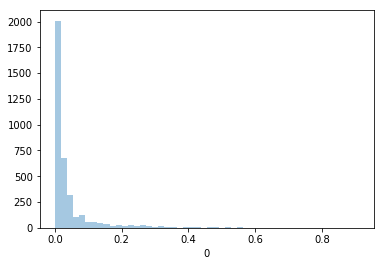

,level_0,level_1,0
979,CAB,PICKUP,0.911305
199,PICKUP,CAB,0.911305
1603,COUPE,2D,0.872834
1063,2D,COUPE,0.872834
1918,3.3,MINIVAN,0.843722


In [12]:
corrmat = dummy_feats.corr().abs()#create correlation matrix
c = corrmat.unstack().reset_index()
#take a look at the distribution of the higher correlated pairs.

#plot a histogram
fig = sns.distplot(c[c[0] != 1][0],kde=False,bins=50)
plt.show()
c[c != 1].sort_values(by=0,ascending=False).head(5)

In [13]:
d = c.loc[(c[0]!=1) & (c[0]>.5)]
d = d.rename(columns={0:'corr'})
d.head(3)


,level_0,level_1,corr
199,PICKUP,CAB,0.911305
208,PICKUP,QUAD,0.528252
274,6C,4.2,0.829285


In [14]:
corrgroup = d.groupby('level_0')['level_1'].value_counts()
pdf['n_corrs>.5'] = corrgroup.groupby('level_0').describe().reset_index()['count']
corrgroup = d.groupby('level_0')['level_1'].value_counts()
pdf['avg_corr'] = d.groupby('level_0')['corr'].mean().reset_index()['corr']
pdf.fillna(0,inplace=True)

In [15]:
'''#A quick visuaization,
sns.set_style('darkgrid')
g = sns.PairGrid(pdf, diag_sharey=False)

g.map_upper(plt.scatter, alpha=.5)

g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

g.map_diag(sns.kdeplot, lw=3)
plt.show()
'''


"#A quick visuaization,\nsns.set_style('darkgrid')\ng = sns.PairGrid(pdf, diag_sharey=False)\n\ng.map_upper(plt.scatter, alpha=.5)\n\ng.map_lower(sns.regplot, scatter_kws=dict(alpha=0))\n\ng.map_diag(sns.kdeplot, lw=3)\nplt.show()\n"

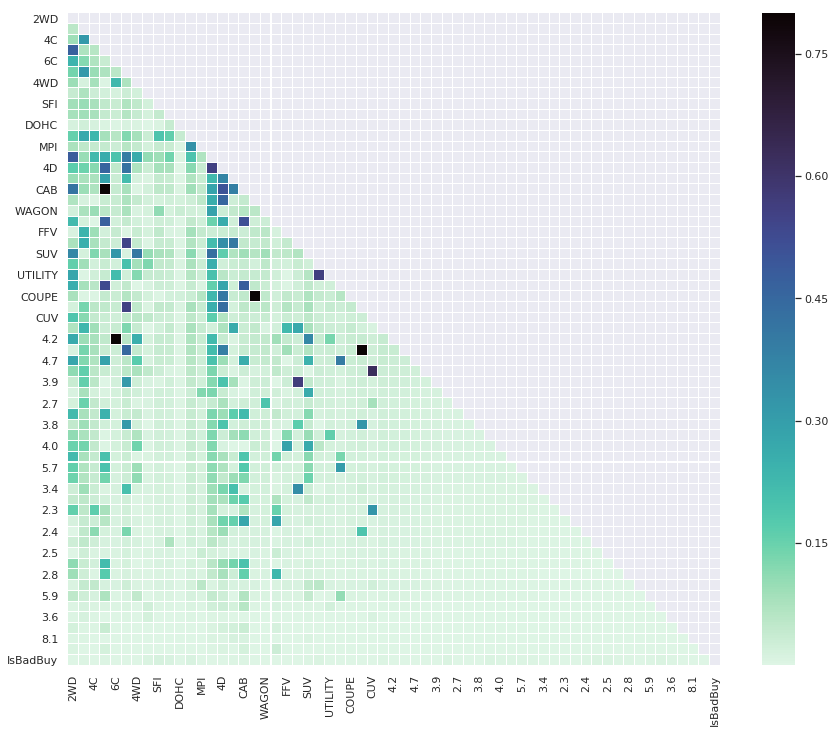

In [16]:
sns.set(palette='YlGnBu')
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
    
with sns.axes_style('dark'):    
    ax = plt.subplots(figsize=(15,12))

    sns.heatmap(corrmat,
            vmax=.8, 
            cmap="mako_r",
            annot=False,
            linewidth=.02,
            square=True,
            mask=mask)


plt.show()

In [17]:
#subtract everything from everything
plodf= df[['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
 'VehicleAge','VehOdo','WarrantyCost','IsBadBuy']].copy()
plodf.dropna(inplace=True)
plodf['crcp_cacp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentAuctionCleanPrice
plodf['arcp_aacp'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRAcquisitionAuctionCleanPrice
plodf['crap_caap'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRCurrentAuctionAveragePrice
plodf['arap_aaap'] = plodf.MMRAcquisitionRetailAveragePrice - plodf.MMRAcquisitionAuctionAveragePrice

plodf['caap_aaap'] = plodf.MMRCurrentAuctionAveragePrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['cacp_aacp'] = plodf.MMRCurrentAuctionCleanPrice - plodf.MMRAcquisitionAuctionCleanPrice
plodf['crap_arap'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRAcquisitionRetailAveragePrice
plodf['crcp_arcp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRAcquisitonRetailCleanPrice

plodf['crcp_crap'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentRetailAveragePrice
plodf['arcp_arap'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRAcquisitionRetailAveragePrice
plodf['cacp_caap'] = plodf.MMRCurrentAuctionCleanPrice - plodf.MMRCurrentAuctionAveragePrice
plodf['aacp_aaap'] = plodf.MMRAcquisitionAuctionCleanPrice - plodf.MMRAcquisitionAuctionAveragePrice

plodf['crcp_caap'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentAuctionAveragePrice
plodf['arcp_aaap'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['crap_cacp'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRCurrentAuctionCleanPrice
plodf['arap_aacp'] = plodf.MMRAcquisitionRetailAveragePrice - plodf.MMRAcquisitionAuctionCleanPrice

plodf['crcp_arap'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRAcquisitionRetailAveragePrice
plodf['arcp_crap'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRCurrentRetailAveragePrice
plodf['cacp_aaap'] = plodf.MMRCurrentAuctionCleanPrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['aacp_caap'] = plodf.MMRAcquisitionAuctionCleanPrice - plodf.MMRCurrentAuctionAveragePrice

plodf['crcp_aacp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRAcquisitionAuctionCleanPrice
plodf['arcp_cacp'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRCurrentAuctionCleanPrice
plodf['crap_aaap'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['arap_caap'] = plodf.MMRAcquisitionRetailAveragePrice - plodf.MMRCurrentAuctionAveragePrice

plodf['crcp_crap_cacp_caap'] = plodf['crcp_crap']-plodf['cacp_caap']
plodf['arcp_arap_aacp_aaap'] = plodf['arcp_arap']-plodf['aacp_aaap']

plodf['crcp_cacp_arcp_aacp'] = plodf['crcp_cacp']-plodf['arcp_aacp']
plodf['crap_caap_arap_aaap'] = plodf['crap_caap']-plodf['arap_aaap']

plodf['crcp_caap_arcp_aaap'] = plodf['crcp_caap']-plodf['arcp_aaap']
plodf['crap_cacp_arap_aacp'] = plodf['crap_cacp']-plodf['arap_aacp']

plodf['crcp_arap_arcp_crap'] = plodf['crcp_arap']-plodf['arcp_crap']
plodf['cacp_aaap_aacp_caap'] = plodf['cacp_aaap']-plodf['aacp_caap']

plodf['crcp_aacp_arcp_cacp'] = plodf['crcp_caap']-plodf['arcp_aaap']
plodf['crap_aaap_arap_caap'] = plodf['crap_cacp']-plodf['arap_aacp']

In [18]:
plodf.shape

(67275, 46)

In [19]:
plodf['crcp_cacp_war'] = plodf['crcp_cacp']* df.WarrantyCost/df.VehicleAge

In [20]:
plodf['crcp_cacp_logwar'] = plodf['crcp_cacp_war']

In [21]:
plodf['crcp_cacp_losqwar'] = plodf['crcp_cacp']* df.WarrantyCost/np.sqrt(df.VehicleAge)

In [22]:
plodf['crap_aaap_war'] = plodf['crap_aaap']* df.WarrantyCost/df.VehicleAge

In [23]:
plodf['log_war_age'] = df.WarrantyCost/df.VehicleAge

In [24]:
plodf['odo_age'] = np.log(df.VehOdo/df.VehicleAge)

In [25]:
plodf['odo_war'] = np.log((df.WarrantyCost/df.VehOdo))
plodf['another'] = np.log(df.WarrantyCost/df.VehOdo**2)
plodf['ugh'] = plodf.VehicleAge * (plodf.crcp_caap/plodf.WarrantyCost)

In [26]:
price_pvals = pd.DataFrame()
prices = []
pvals = []
for col in plodf: 
    tstat = stats.ttest_ind(
    plodf[plodf.IsBadBuy == 1][col],
    plodf[plodf.IsBadBuy == 0][col])
    prices.append(col)
    pvals.append(tstat.pvalue)
price_pvals['price'] = prices
price_pvals['pvalues'] = pvals

In [27]:
price_pvals.sort_values(by='pvalues',inplace=True)
cont_df = plodf[['odo_age','log_war_age','crcp_cacp_war']]

In [28]:
#combine the three new dataframes
mod_val_sets.reset_index(drop=True,inplace=True)
sub_val_sets.reset_index(drop=True,inplace=True)
disp_keys.reset_index(drop=True,inplace=True)
cont_df.reset_index(drop=True,inplace=True)

add_feats = pd.concat([mod_val_sets,sub_val_sets,disp_keys,cont_df],axis=1)


In [29]:
df.shape,add_feats.shape

((67275, 29), (67275, 63))

In [30]:
#combine new features to our existing attributes
df.reset_index(drop=True,inplace=True)
model_df = pd.concat([df,add_feats],axis=1)

In [31]:
model_df.drop(['SubModel'],1,inplace=True)
model_df.Model = model_df.Model.str.split().str[0].str.strip()

bad smote

In [32]:
scaler = preprocessing.StandardScaler()

In [43]:
X = model_df.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)
#X = scaler.fit_transform(X)
y = model_df.IsBadBuy

sm = SMOTE(random_state=163,sampling_strategy=.7)
X_res, y_res = sm.fit_resample(X, y)

In [44]:
print(X_res.shape)
print(y_res.mean())

(103429, 533)
0.4117607247483781


In [45]:
#X_train = X_res
#y_train = y_res
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.5,random_state=167)

In [ ]:
#run a loop test a number of different parameters on the same data
n_ests = []
max_d = []
min_samples_split = []
min_sam_leaf = []
TN = []
FN = []
FP = []
TP = []
roc_auc = []
for i in range(3,11,1):
    for j in range(5,13,1):
        for k in range(2,8):
            for l in range(1,6):
                params = {'n_estimators': i*100,
                      'max_depth': j,
                      'criterion': 'gini',
                      'min_samples_leaf':l,
                      'class_weight':'balanced',
                      'min_samples_split':k  }
                # Initialize and fit the model.
                clf = ensemble.RandomForestClassifier(**params)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                # Accuracy tables.
                conf = confusion_matrix(y_test,y_pred)
                tns = conf[0][0]
                fps = conf[0][1]
                tps = conf[1][1]
                fns = conf[1][0]
                #append info
                n_ests.append(i*100)
                max_d.append(j)
                min_samples_split.append(k)
                min_sam_leaf.append(l)
                TN.append(tns)
                FN.append(fns)
                FP.append(fps)
                TP.append(tps)
                roc_auc.append(roc_auc_score(y_test,y_pred))

In [ ]:
results = pd.DataFrame()
results['n_estimates'] = n_ests
results['max_d'] = max_d
results['min_samples_split'] = min_samples_split
results['mins_samples_leaf'] = min_sam_leaf
results['TN'] = TN
results['FN'] = FN
results['FP'] = FP 
results['TP'] = TP
results['roc_auc'] = roc_auc

In [42]:
results.sort_values(by='roc_auc', ascending=False)

,n_estimates,max_d,min_samples_split,mins_samples_leaf,TN,FN,FP,TP,roc_auc
248,500,9,4,3,16723,1039,7564,1584,0.646223
357,600,10,5,1,17334,1108,6953,1515,0.645649
452,700,10,4,3,17165,1092,7122,1531,0.645220
68,300,10,4,3,17235,1100,7052,1523,0.645136
59,300,9,5,3,16593,1031,7694,1592,0.645072
440,700,9,4,3,16657,1038,7630,1585,0.645055
435,700,9,3,1,16855,1060,7432,1563,0.644938
51,300,9,3,1,16897,1065,7390,1558,0.644849
350,600,10,2,3,17183,1096,7104,1527,0.644828
250,500,9,5,2,16734,1050,7553,1573,0.644353
